![PNS](http://caillau.perso.math.cnrs.fr/logo-pns.png)
## MAM4 - EDP1
# TP 2 - Équation d'advection

## Exercice 1. Schéma explicite

On résout numériquement l'équation d'advection sur $\Omega:=]0,L[$ avec conditions aux limites périodiques.

$$ \left\{\begin{array}{l}
\displaystyle \frac{\partial u}{\partial t}(x,t)+V\frac{\partial
  u}{\partial x}(x,t)=0,x\in\Omega,\,t\ge 0,\\
\displaystyle u(x,0)=u_0(x),\,x\in \Omega,\\
u(0,t)=u(L,t),\,t\ge 0.
\end{array}\right. $$

Pour simplifier on a supposé que la donnée initale
est périodique de période $L$. On vérifie aisément que la
solution exacte est donnée par $u(x,t)=u_0(x-Vt)$.

On cherche à approcher numériquement la solution par le schéma *décentré amont* suivant:

$$ \frac{u_j^{n+1}-u_j^n}{\Delta t}+V\frac{u_j^n-u_{j-1}^n}{\Delta x}=0 $$ 

où $u_j^n \simeq u(x_j,t_n),\,0\le j\le N$, $\Delta x=L/N$,
$x_j=j\Delta x$ et $t_n = n\Delta t$. En réarrangeant les termes, on obtient

$$ u_j^{n+1}=u_j^n-\sigma(u_j^n-u_{j-1}^n) $$

où $\sigma=\displaystyle\frac{V\Delta t}{\Delta x}$ est connu sous le nom de [*nombre de Courant*](https://fr.wikipedia.org/wiki/Nombre_de_Courant).
Pour approcher la condition initiale et la condition limite on écrit

$$ u_j^0=u_0(x_j),\,0\le j\le N,\, u_0^n = u_N^n,\,n\ge 0. $$

Augmenter progressivement le paramètre $\sigma$ et observer le résultat. Quelle est la valeur critique ? Constater aussi en augmentant progressivement `Nt` que la solution numérique est amortie au fil des itérations en temps (phénomène de diffusion numérique).

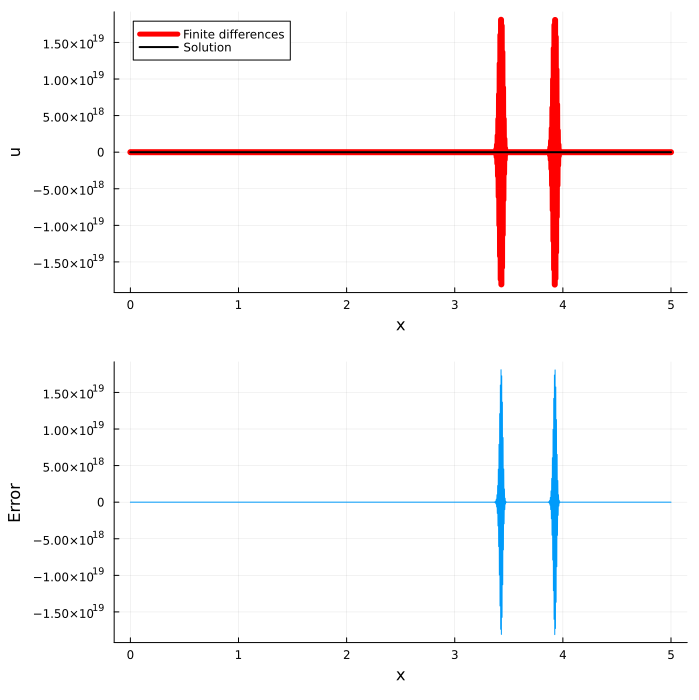

Δx: 0.003125	 Δt:0.0315625	 max error: 1.8098092266663526e19


In [1]:
using LinearAlgebra, SparseArrays, Plots
  
# Parameters
V = 0.1                                             # advection speed
L = 5                                               # domain length
Nx = 1600                                           # space grid size
x = range(0, L, length = Nx+1)                      # space grid
Δx = x[2]-x[1]                                      # space stepsize
σ = 1.01                                            # Courant number
Δt = σ*Δx/V                                         # time stepsize
Nt = 2400                                           # time grid size     
tf = Nt * Δt                                        # final time
u0 = x -> begin                                     # characteristic function
    y = mod.(x, L)
    Float64.((y.>1.0) .& (y.<1.5))
end
#u0 = x -> sin.(8*π*x/L)                             # sine pulse

# Explicit scheme
u = u0(x)

for n = 1:Nt
    u[2:end] = u[2:end]-σ*(u[2:end]-u[1:end-1])
    u[1] = u[end]
end

uexact = u0(x.-V*tf)
err = u - uexact
u_plot = plot(x, u, xlabel="x", ylabel="u", color=:red, label="Finite differences", lw=6)
plot!(u_plot, x, uexact, xlabel="x", ylabel="u", color=:black, label="Solution", lw=2)
err_plot = plot(x, err, xlabel="x", ylabel="Error", legend=false)
display(plot(u_plot, err_plot, layout=(2, 1), size=(700, 700)))
println("Δx: ", Δx, "\t Δt:", Δt, "\t max error: ", maximum(abs.(err)))

## Exercice 2. Schéma de Lax-Wendroff
En suivant le modèle précédent, implémenter le schéma suivant :

$$
u_j^{n+1}=u_j^n-\frac{\sigma}{2}(u_{j+1}^n-u_{j-1}^n)+\frac{\sigma^2}{2}(u_{j+1}^n-2u_j^n+u_{j-1}^n).
$$

Dans ce nouveau script au tout début, à l'intérieur de la boucle en temps on va fixer la condition à un des bords (condition entrante) :
```julia
u[1] = u0(x[1]-V*(n-1)*Δt)
u[end] = u[1]
```

Repartir de $\sigma=0.8$ et tester plusieurs possibilités du couple conditions initiale/schéma numérique. 

- Quelles conditions tirez-vous ?
- Augmenter progressivement $\sigma$ pour le schéma de Lax-Wendroff et observer. 
- Que peut-on dire de la diffusion numérique observée précédemment dans le cas du schéma décentré ?
- Le schéma de Lax-Wendroff est-il diffusif ?

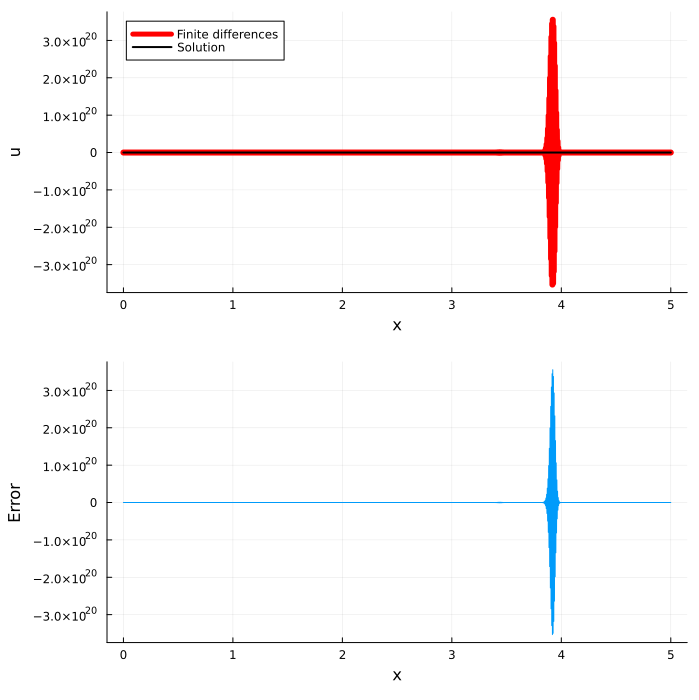

Δx: 0.003125	 Δt:0.0315625	 max error: 3.552928373375565e20


In [2]:
# Explicit Lax-Wendroff scheme
u = u0(x)

for n = 1:Nt
    u[2:end-1] = u[2:end-1] - σ/2*(u[3:end]-u[1:end-2]) + σ^2/2*(u[3:end]-2*u[2:end-1]+u[1:end-2])
    u[1] = u0(x[1]-V*n*Δt)
    u[end] = u[1]
end

uexact = u0(x.-V*tf)
err = u - uexact
u_plot = plot(x, u, xlabel="x", ylabel="u", color=:red, label="Finite differences", lw=6)
plot!(u_plot, x, uexact, xlabel="x", ylabel="u", color=:black, label="Solution", lw=2)
err_plot = plot(x, err, xlabel="x", ylabel="Error", legend=false)
display(plot(u_plot, err_plot, layout=(2, 1), size=(700, 700)))
println("Δx: ", Δx, "\t Δt:", Δt, "\t max error: ", maximum(abs.(err)))

## Exercice 3. Schéma de Lax-Wendroff implicite
On va changer le schéma comme suit :

$$
u_j^{n+1}=u_j^n-\frac{\sigma}{2}(u_{j+1}^n-u_{j-1}^n)+\frac{\sigma^2}{2}(u_{j+1}^{n+1}-2u_j^{n+1}+u_{j-1}^{n+1}).
$$ 

En introduisant $W^n = (u_j^n-\frac{\sigma}{2}(u_{j+1}^n-u_{j-1}^n))_j$ et
$U^n=(u_j^n)_j$,
le schéma s'écrit $AU^{n+1}=W^n$. On pourra utiliser la
condition de périodicité directement dans le schéma numérique afin d'éliminer $u_j^N$. On constate que le schéma est implicite : l'évaluation de $U^{n+1}$ à partir
de $U^n$ nécessite la résolution d'un système linéaire, et le coût
de l'itération sera plus élevé que dans le cas d'un
schéma explicite. Cependant le schéma n'est pas limité par la
valeur du nombre de Courant $\sigma$ ce qui permet d'utiliser des
pas de temps plus grands et donc de diminuer le nombre d'itérations associé.

Deux options sont possibles pour la boucle en temps : 
- soit résoudre le système linéaire à chaque pas de temps (factorisation, pas inversion !)
- soit factoriser la matrice $A$ une fois pour toutes avant la boucle (par exemple sous la forme $A=LU$), puis réutiliser cette factorisation.

Comparer ces différentes options pour la résolution
du systéme linéaire en observant le temps d'execution et en augmentant progressivement la taille du système à résoudre. Réaliser des expériences numériques en
faisant varier le nombre de Courant. Discuter les performances relatives des schémas implicite et explicite en termes de temps de calcul.

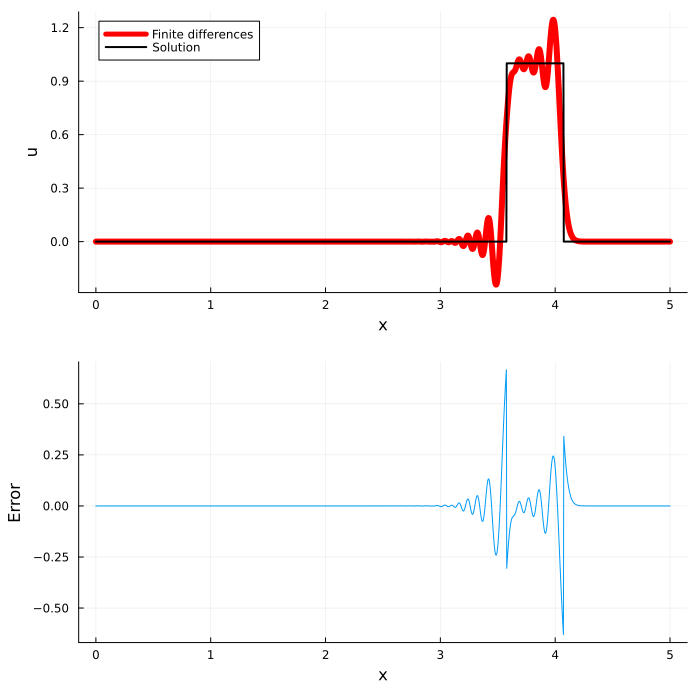

Δx: 0.003125	 Δt:0.0315625	 max error: 0.666660496234014


In [3]:
# Implicit Lax-Wendroff scheme
u = u0(x)

A = spdiagm(-1 => -σ^2/2*ones(Nx), 0 => (1+σ^2)*ones(Nx+1), 1 => -σ^2/2*ones(Nx))
A[1, end] = -σ^2/2
A[end, 1] = -σ^2/2

F = cholesky(A) # Cholesky factorisation on sparse symmetric matrix

w = zeros(Nx+1)

for n = 1:Nt
    w[2:end-1] = u[2:end-1] - σ/2*(u[3:end]-u[1:end-2])
    w[1] = u0(x[1]-V*n*Δt)
    w[end] = w[1]
    u = F\w
end

uexact = u0(x.-V*tf)
err = u - uexact
u_plot = plot(x, u, xlabel="x", ylabel="u", color=:red, label="Finite differences", lw=6)
plot!(u_plot, x, uexact, xlabel="x", ylabel="u", color=:black, label="Solution", lw=2)
err_plot = plot(x, err, xlabel="x", ylabel="Error", legend=false)
display(plot(u_plot, err_plot, layout=(2, 1), size=(700, 700)))
println("Δx: ", Δx, "\t Δt:", Δt, "\t max error: ", maximum(abs.(err)))